In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import numpy as np


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# CRFAR10 Dataset

![alt text](https://drive.google.com/uc?id=1WZK7z4pa3qdXmg7fs9AnqlflCTGzblz1)

0it [00:00, ?it/s]

170500096it [00:06, 27770209.17it/s]                               


Extracting ../../data/cifar-10-python.tar.gz to ../../data/
Files already downloaded and verified
Train dataset size =  50000
Test dataset size =  10000
Image size =  torch.Size([3, 32, 32]) ( 9 )


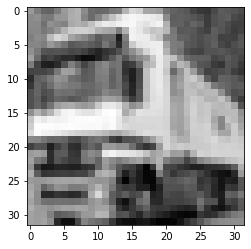

In [3]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor()
])


# CIFAR-10 dataset
train_dataset = dataset.CIFAR10(root='../../data/', train=True, transform=transform, download=True)
test_dataset = dataset.CIFAR10(root='../../data/', train=False, transform=transform, download=True)


print('Train dataset size = ',len(train_dataset))
print('Test dataset size = ',len(test_dataset))
img, label = train_dataset[1]
print('Image size = ',img.shape, '(', label, ')')
plt.imshow(img[0,:,:], cmap='gray') 



# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)


del train_dataset
del test_dataset

# Neural Network Model

Layer       | Operations                            | Input Size    | Output Size
------------| --------------------------------------|---------------|---------------
Layer 1     | conv3x3 + BatchNorm + Relu            | 3 x 32 x 32   | 128 x 32 x 32
Layer 2     | conv3x3 + BatchNorm + Relu + maxpool  | 128 x 32 x 32 | 256 x 16 x 16
Layer 3     | conv3x3 + BatchNorm + Relu            | 256 x 16 x 16 | 128 x 16 x 16
Layer 4     | conv3x3 + BatchNorm + Relu + maxpool  | 128 x 16 x 16 |  64 x  8 x 8
Layer 5     | Fully connected                       |  1 x  4096    |  1 x  512
Layer 6     | Fully connected                       |  1 x  512     |  1 x  10


In [0]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1, stride=1)       
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)
        self.n = np.int(4096)
        
        self.linear1 = nn.Linear(self.n, 128)                              
        self.linear2 = nn.Linear(128, num_classes)                        
        self.relu = nn.ReLU()                                                  
        self.max_pool = nn.MaxPool2d(2, stride=2)
        
        self.init()
    
    def init(self):
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.xavier_uniform_(self.conv4.weight)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        
        
    def forward(self, x):
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.max_pool(out)
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.relu(self.bn4(self.conv4(out))) 
        out = self.max_pool(out)
        
        out = out.view(out.size(0), -1)
        out = nn.functional.dropout(out, 0.5)
        out = self.relu(self.linear1(out))
        out = self.linear2(out)
        return out
      

In [0]:
num_classes = 10
learning_rate = 0.001

model1 = Model(num_classes).to(device)
model2 = Model(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.8, weight_decay=5e-4)


In [0]:
# Train the model
def Train(model, optimizer, num_epochs):
    total_step = len(train_loader)
    loss_val = []
    count = []
    
    model.train()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            if (i+1) % 100 == 0:
                count.append(i+1 + epoch*total_step)
                loss_val.append(loss.item())
                print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'%(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    return count, loss_val

In [0]:
# Test the model
def Test(model):
    correct = 0
    total = 0

    actual_labels = []
    predicted_labels = []
    
    model.eval()
    
    for images, labels in test_loader:
    
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

        labelsCPU = labels.data.cpu().numpy()
        predictedCPU = predicted.data.cpu().numpy()
        predicted_labels.append(predictedCPU)
        actual_labels.append(labelsCPU) 
    
    print('Accuracy of the model = %f'%(100 * correct / total))    
    

In [18]:
num_epochs = 20
count, loss1 = Train(model1, optimizer1, num_epochs)

count, loss2 = Train(model2, optimizer2, num_epochs)

Epoch [1/20], Step [100/391], Loss: 1.6646
Epoch [1/20], Step [200/391], Loss: 1.4609
Epoch [1/20], Step [300/391], Loss: 1.2099
Epoch [2/20], Step [100/391], Loss: 1.0751
Epoch [2/20], Step [200/391], Loss: 0.8747
Epoch [2/20], Step [300/391], Loss: 0.9839
Epoch [3/20], Step [100/391], Loss: 0.9291
Epoch [3/20], Step [200/391], Loss: 0.8544
Epoch [3/20], Step [300/391], Loss: 0.8462
Epoch [4/20], Step [100/391], Loss: 0.7348
Epoch [4/20], Step [200/391], Loss: 0.7152
Epoch [4/20], Step [300/391], Loss: 0.5871
Epoch [5/20], Step [100/391], Loss: 0.6783
Epoch [5/20], Step [200/391], Loss: 0.6099
Epoch [5/20], Step [300/391], Loss: 0.6630
Epoch [6/20], Step [100/391], Loss: 0.6457
Epoch [6/20], Step [200/391], Loss: 0.6838
Epoch [6/20], Step [300/391], Loss: 0.5626
Epoch [7/20], Step [100/391], Loss: 0.5235
Epoch [7/20], Step [200/391], Loss: 0.5136
Epoch [7/20], Step [300/391], Loss: 0.5471
Epoch [8/20], Step [100/391], Loss: 0.4820
Epoch [8/20], Step [200/391], Loss: 0.6449
Epoch [8/20

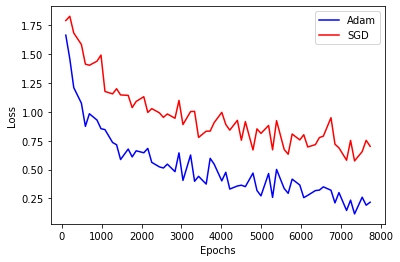

Adam Optimizer
Accuracy of the model = 80.000000
SGD Optimizer
Accuracy of the model = 71.000000


In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(count, loss1, color='blue', label='Adam')
plt.plot(count, loss2, color='red', label='SGD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print('Adam Optimizer')
Test(model1)

print('SGD Optimizer')
Test(model2)